# Сверточные нейронные сети

* [Wiki - Свёрточная нейронная сеть](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C)
* [Лекция. Сверточные нейронные сети - Deep Learning School](https://www.youtube.com/watch?v=HpKGv-kYurk)
* [Как работает сверточная нейронная сеть (CNN)](https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/)
* [Визуализация CNN](https://animatedai.github.io/)
* Компьютерное зрение. Теория и алгоритмы - Рейнхард Клетте

## Мотивация к применению

В [серии конспектов](https://github.com/castargo/ML_DL_experiments/tree/main/nn/basics) про основы полносвязных нейронных сетей упомяналось, что по [теореме Хорника](https://en.wikipedia.org/wiki/Universal_approximation_theorem) известно, что нейронная сеть с одним скрытым слоем является универсальным аппроксиматором, то есть может аппроксимировать непрерывную функцию любого типа. Тогда в чем заключается мотивация использования, например, сверточных нейронных сетей?

У полносвязных нейронных сетей есть особенности, которые затрудняют обучении при работе с данными, имеющими структуру: картинками, аудио- и видеозаписями, последовательностями и т.п. Вспомним [пример](https://github.com/castargo/ML_DL_experiments/blob/main/nn/basics/04_gradient_descent.ipynb) с обучением полносвязной нейронной сети на датасете MNIST. Там мы "разворачивали" изображение в массив следующим образом:

```python
image_tensor.flatten().numpy()
```

Такой способ представления не учитывает особенности структуры (пиксельной сетки) изображения. Полносвязная нейронная сеть выучивает зависимость "развернутого" изображения, создавая некоторую маску, которую затем пытается предсказать на других изображениях-векторах. Тогда если изображения в тестовой выборке будут отличаться от тренировочной (например, объект будет находиться в другой части изображения, будет меньше или больше и т.п.), полносвязная нейронная сеть не сможет сделать корректный прогноз. Мы могли бы добавить в обучающую выборку больше примеров, чтобы у каждого класса было больше специфичных масок, но тогда и нейронная сеть должна иметь больше обучаемых параметров. 

В основе сверточных нейронных сетей лежит идея, которая помогает эффективно решить обе эти проблемы: будем сохранять сеточную структуру изображения, но использовать некоторое "скользящее окно", называемое **сверткой** для локализации зависимостей на изображении. Так мы преодолеем проблему перемещающегося объекта на изображении, ведь **операция свертки инвариантна** относительно ее местоположения.

## Предтечи сверточных нейронных сетей

Идея операции свертки во многом была сформирована при изучении зрительного аппарата человека. Первые работы по изучению зрительной коры головного мозга были опубликованы Хьюбелом и Визелем в 1950-х. В 1959 году исследователи предложили модель, согласно которой, существует два вида клеток в первичной зрительной коре: простая и сложная клетка, расположенные каскадно. Опираясь на эту идею, в 1980 году Кунихико Фукусима предложил модель обучения без учителя для распознавания образов, которая называлась [неокогнитрон](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BE%D0%BA%D0%BE%D0%B3%D0%BD%D0%B8%D1%82%D1%80%D0%BE%D0%BD).

Со временем сформировалась область computer science, которорая стала называться **компьютерным зрением**. Существует множество "традиционных" подходов, связанных с областью цифровой обработки сигналов, в которых изображения рассматривались как двумерные сигналы, на которые, например, применяли различные [фильтры](https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html): линейный фильтр (кросс-корреляция или свертка), фильтр Гаусса для размытия и снижения уровня шума, фильтры Габора для выделения границ объектов на изображениях, фильтры Хаара для распознавания объектов на изображении (для алгоритма Виолы-Джонса) и т.п. [Смотри отличную лекция Андрея Савченко.](https://www.youtube.com/watch?v=L3EBxvSC20M&t=1390s&ab_channel=QAHub)

[Сверточные нейронные сети](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C) были предложены в 1989 году группой исследователей, которую возглавлял Ян Лекун, в статье [Backpropagation Applied to Handwritten Zip Code Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf). Там исследователи впервые применили подход на предке датасета MNIST.

## В общих чертах: сверточные нейронные сети в задачах, связанных с обработкой изображений

В датасете MNIST каждое изображение представлено одномерным тензором размерности ```torch.Size([1, 28, 28])```, в каждой позиции стоит число от 0 до 1 в зависимости от интенсивности цвета в данном пикселе. Изображение является черно-белым.

Чтобы представить цветное изображение, необходим многомерный тензор (например, ```torch.Size([3, 28, 28])```): каждая матрица задает интенсивность цвета в данном пикселе изображения в RGB-представлении. То есть каждому пикселю изображения сопоставляется одномерный тензор, описывающий цветовые свойства этого пикселя, и чьи компоненты называются **каналами**.

> Чтобы закодировать 8-битное изображение, можно использовать числа от 0 до 255: $2^8 = 256$

Идея свёрточных нейронных сетей заключается в чередовании свёрточных слоёв (**convolution layers**) и субдискретизирующих слоёв (**pooling layers, subsampling**). Структура сверточной нейронной сети является однонаправленной (без обратных связей) и многослойной. На вход подается изображение (многомерный тензор), которое проходит через серию сверточных слоев, в которых чередуются операции свертки и субдискретизации (пулинг). Такой подход с чередованием слоев позволяет выделять из изображений сложные зависимости и низкоуровневые признаки (feature map). Как правило, после нескольких слоев свертки и пулинга многмерный тензор приводится к вектору или скаляру. Также на выходе сверточной нейронной сети может быть несколько полносвязных слоев.

<img src="pictures/CNN.jpg" width=600 height=600 />

### Сверточный слой (convolutional layer)

Принцип работы сверточного слоя заключается в применении операции свертки с некоторым **ядром свертки** к входному изображению. Если изображение является цветным, то есть оно представлено несколькими каналами (является многомерным тензором), то и ядро свертки тоже будет многомерным тензором, где у каждого канала будет своя маска (фильтр). К слову, количество каналов после сверточного слоя может увеличиться:

$$N \text{ каналов на входе: свертка размера } N \times M \rightarrow M \text{ каналов на выходе}$$

**Ядро свертки** - это, как правило, небольшая матрица, чьи коэффициенты не задаются заранее, а являются обучаемыми параметрами (весами), оптимизируемыми в процессе схождения градиентного спуска (не забываем про bias). На соответствующем слое инициализируется некоторое ядро свертки, которое затем двигают по всему обрабатываемому слою. При этом разные ядра могут **кодировать разные элементы изображения**: участки, линии, дуги и т.п. Проход каждым набором весов формирует свой собственный экземпляр карты признаков (**feature map**) - выходной тензор, делая нейронную сеть многоканальной (много независимых карт признаков на одном слое). Следущий слой, получающий на вход результаты свертки текущего слоя, будет "кодировать" более высокоуровневую информацию, таким образом используя пространственные корреляции на изображениях.

> Local respective fields (пятно восприятия)

Свертка - некоторое линейное преобразование входных данных (скалярное умножение элементов матрицы окна на матрицы свертки, а не произведение матриц). Легче всего механизм ее работы рассмотреть на одноканальном изображении (матрице). Тогда алгоритм применения свертки к изображению будет следующим:
1. Изображение разбивается на фрагменты-матрицы
2. Каждый фрагмент "сворачивается" при помощи ядра свертки (в этом случае тоже матрицы)
3. Значения свертки последовательно переносятся в выходную матрицу меньшего размера

На изображении ниже:
* input - вход сверточного слоя
* output - выход сверточного слоя (feature map)
* небольшая матрица - ядро свертки

<img src="pictures/convolution_inp_out.png" width=600 height=600 />

А вообще, к значению ячейки при обучении нейронной сети добавляется еще и bias.

#### Padding (отступ)

На картинке выше после свертки мы получили выходной тензор того же размера, что и входной, при помощи трюка с добавлением фиктивной "рамки" толщины 1, дублирующей крайние элементы тензора. Вообще, такая "рамка" называется **padding** и может заполняться и другими значениями, например, нулями.

#### Stride (шаг)

Обязательно ли нам всегда двигать свертку только на один пиксель вправо-влево и вверх-вниз? Нет, шаг (**stride**) может быть любого размера, и тогда мы будем "перескакивать" колонки и строчки нашего изображения. Стоит ли двигать свертку на размер матрицы весов? Вообще, нет, ведь так можно пропустить полезные признаки на изображении.

### Слой пулинга (субдискретизирующий слой, subsampling, pooling layers)

Для того, чтобы добиться хорошего перформанса от сверточных нейронных сетей, нам нужно научиться **эфективно "снижать размерность"** входного изображения, то есть "просматривать" полученные после свертки карты признаков и отбирать оттуда наиболее полезные. В этом помогает **операция пулинга (pooling, subsampling)**: 
* Задается параметр, который разбивает изображение на непересекающиеся группы признаков (например, квадраты размера 2×2 пикселя)
* При помощи какой-то нелинейной (чаще всего) или линейной операции из каждой группы отбирается один признак (пиксель)
* Из отобранных пикселей формируется выход слоя пулинга

В результате операции пулинга мы "сжимаем" входное изображение, уплотняя непересекающиеся группы признаков. Можно выделить следующие достоинства данной операции:
* Ускорение вычислений (изображение на выходе меньше, чем на входе)
* Устойчивость сети к размеру входного изображения
* Фильтрация малозначимых признаков помогает в борьбе с переобучением
* Акцент на наличии признака на изображении, а не на его расположении

Виды пулинга:
* MaxPooling
* MinPooling
* AvgPooling
* L2-нормирование

Пример MaxPooling:

<img src="pictures/pooling.png" width=400 height=400 />

### Объединяем слои в CNN

Итак, мы определили слой свертки и слой пулинга, будем собирать из них (и не только) сверточную нейронную сеть. Есть несколько основных правил:
* Последовательно применяем на входном изображении одну или более операций свертки, при этом, как правило, на каждом следующем слое увеличивается число каналов и уменьшается размерность изображения в каждом канале. Новый набор каналов представляет изображение с точки зрения абстрактных признаков, которые оно содержит.
* После свертки почти всегда следует нелинейная функция активации, например ReLU. Часто даже по умолчанию считается, что функция активации встроена в слой свертки.
* Слой пулинга, как правило, вставляется после слоя свёртки перед слоем следующей свёртки.
* После нескольких итераций данные объединяются и передаются на многослойную полносвязную нейронную сеть (здесь нам уже не важна пространственная структура в данных). 
* На выходе из нейронной сети используется функция активации Softmax.

Наиболее популярный способ обучения сверточных нейронных сетей - метод обратного распространения ошибки и его модификации: [Backpropagation In Convolutional Neural Networks](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)

Что можно предпринять в случае переобучения?
* Уменьшить число слоев
* Уменьшить кол-во фильтров в сверточных слоях
* Увеличить коэффициент дропаута

### Convolution arithmetic

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

#### Пример из [wiki](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C)

Особенностью свёрточного слоя является сравнительно небольшое количество параметров, устанавливаемое при обучении. Так например, если исходное изображение имеет размерность 100×100 пикселей по 3-м каналам (это значит 30 000 входных нейронов), а свёрточный слой использует фильтры c ядром 3×3 пикселя с выходом на 6 каналов, тогда в процессе обучения определяется только 9 весов ядра, однако по всем сочетаниям каналов, то есть 9×3×6=162 (9 весов, 3 канала входных, 6 каналов выходных), в таком случае данный слой требует нахождения только **162 параметров**, что существенно меньше количества искомых параметров полносвязной нейронной сети.

Замечание: видимо, в примере нет bias.

#### Размер тензора после свертки
* Входное изображение 36x36x3 пикселей 
* Свертка 8 фильтров размера 3x3x3, padding=1, stride=2

Для изображения, у которого $W = H$ ([смотри документацию](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)):

$$W_{\text{out}} = [\frac{(W_{\text{in}} + 2 \text{padding} - (\text{kernel size} - 1) - 1)}{\text{stride}} + 1]$$

$$\text{math.floor}( \frac{(36 + 2 - (3 - 1) - 1)}{2} + 1)= 18$$

Размер тензора после свертки: 18x18x8

#### Параметры в слое
* Входное изображение 128x128x3
* Свертка 3x3, padding=1, stride=1
* Кол-во выходных каналов=10

$$\text{in_channels * out_channels * kernel_size + bias}$$

$$\text{bias = out_channels}$$

Тогда кол-во настраиваемых параметров: 3 * 10 * 9 + 10 = 280

```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

## LeNet-5 PyTorch

In [2]:
import torch
import torchvision

import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

np.random.seed(0)

### Выгрузим данные

In [3]:
mnist_train = MNIST(root='data/',
                    train=True,
                    transform=transforms.Compose([
                        transforms.Resize((32,32)),
                        transforms.ToTensor(), 
                        transforms.Normalize(mean=(0.1307,), std=(0.3081,))]),
                    download=True)

mnist_test = MNIST(root='data/',
                   train=False,
                    transform=transforms.Compose([
                        transforms.Resize((32,32)),
                        transforms.ToTensor(), 
                        transforms.Normalize(mean=(0.1307,), std=(0.3081,))]),
                    download=True)

In [4]:
BATCH_SIZE = 256
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [5]:
image_tensor, label = mnist_test[0]
image_tensor.shape, label

(torch.Size([1, 32, 32]), 7)

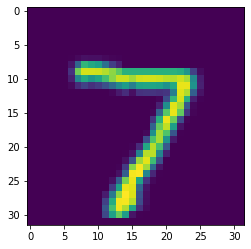

In [6]:
plt.imshow(image_tensor[0, 0:32, 0:32]);

### Обучение модели

<img src="pictures/lenet5.png" width=700 height=700 />

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU())
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU())
        self.out = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [8]:
LEARNING_RATE = 0.01
NUM_EPOCH = 10

In [9]:
model = LeNet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [10]:
for epoch in range(NUM_EPOCH):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{NUM_EPOCH}], loss: {round(loss.item(), 5)}')

Epoch [1/10], loss: 1.92073
Epoch [2/10], loss: 0.7912
Epoch [3/10], loss: 0.40254
Epoch [4/10], loss: 0.30409
Epoch [5/10], loss: 0.26429
Epoch [6/10], loss: 0.24407
Epoch [7/10], loss: 0.23159
Epoch [8/10], loss: 0.22342
Epoch [9/10], loss: 0.21756
Epoch [10/10], loss: 0.21346


### Метрики модели на тестовой выборке

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {100 * correct / total} %')

Test accuracy: 97.2 %


## История архитектур CNN на примере ILSVRC

[CNN Architectures: LeNet, AlexNet, VGG, GoogLeNet, ResNet and more...](https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)

Первые работы, связанные со сверточными нейронными сетями, были применены на наборе данных с рукописными цифрами MNIST, и уже скоро на нем было достигнуто достаточно высокое качество классификации. Новым челленджем для исследователей на десятилетия стал набор данных ImageNet. В рамках этого проекта проводился ежегодный конкурс программного обеспечения ImageNet Large Scale Visual Recognition Challenge (ILSVRC), в котором исследователи соревновались в максимально достигаемом качестве.

| Год | Архитектура | Исследователи | Место ILSVRC | Top-5 error rate | Количество параметров |
| --- | --- | --- | --- | --- | --- |
| 1998 | LeNet | Yann LeCun |  |  | 60K (7 слоев) |
| 2012 | AlexNet | Alex Krizhevsky, Geoffrey Hinton, Ilya Sutskever | 1 | 15.3% | 60M (8 слоев) |
| 2013 | ZFNet | Matthew Zeiler, Rob Fergus | 1 | 14.8% |  |
| 2014 | VGG | Simonyan, Zisserman | 2 | 7.3% | 138M (19 слоев) |
| 2014 | GoogLeNet | Google | 1 | 6.67% | 4M (22 слоя) |
| 2015 | ResNet | Kaiming He | 1 | 3.6% | (152 слоя) |

### LeNet-5 (1998, Ян Лекун)

[Gradient-based learning applied to document recognition (LeCun, Bottou, Bengio, Haffner)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

Это архитектура из семи слоев использовалась для классификации рукописных чисел на ч/б изображениях размером 32x32 пикселей.

<img src="pictures/lenet5.png" width=700 height=700 />

### AlexNet (2012, SuperVision: Алекс Крижевский, Джеффри Хинтон и Илья Суцкевер)

[ImageNet Classification with Deep Convolutional Neural Networks (Alex Krizhevsky, Geoffrey Hinton, Ilya Sutskever)](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

Долгое время на ILSVRC ошибка составляла порядка 25%, пока в 2012 году не вышла статья AlexNet. Эта сеть имеет схожую с LeNet-5 архитектуру, но имеет большую глубину и большее количество фильтров. И, конечно, использовалась для изображения из 3-х каналов. Использовалась активация ReLU и SGD с импульс. AlexNet обучался в течение 6 дней одновременно на двух графических процессорах Nvidia Geforce GTX 580.

<img src="pictures/alex_net.png" width=700 height=700 />

### ZFNet (2013, Зейлер и Фергюс)

[Visualizing and Understanding Convolutional Networks (Matthew Zeiler, Rob Fergus)](https://arxiv.org/pdf/1311.2901v3.pdf)

Эта сеть является модификацией AlexNet.

### VGG (2014, Симонян и Зиссерман)

[Very Deep Convolutional Networks for Large-Scale Image Recognition (Karen Simonyan, Andrew Zisserman)](https://arxiv.org/pdf/1409.1556v6.pdf)

Архитектура имеет 6 модификаций, наиболее популярная для извлечения признаков - **VGG-16**. Сеть тренировалась на 4 GPU в течение 2–3 недель. Смотри про **receptive field** ниже.

<img src="pictures/vgg16.png" width=700 height=700 />

### GoogleLeNet (Inception) (2014)

[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842v1.pdf)

В архитектуре данной сети впервые были использованы **inception блоки** (выделены овалами на изображении), что позволило добиться высокого качества работы модели при сравнительно (с VGG) небольшом количестве параметров.

Еще одна особенность сети - две полносвязные подсети, которые имеют ту же функцию ошибки и делают промежуточные предсказания. Так мы следим, что градиент не затухнет при пробрасывании его через очень глубокую сеть на примере сетей "поменьше".

<img src="pictures/googlenet.png" width=600 height=600 />

Также от создателей этой архитектуры есть статья [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567.pdf), в которой они предлагают вместо свертки nxn использовать две последовательные свертки nx1 и 1xn.

### ResNet (2015, Кайминг Хе)

[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

Архитектура, которая также называется **Residual Neural Network** (остаточное обучение). Ее особенностями являются сильная батч-нормализация и residual блоки, которые чем-то похожи на RNN. Есть разные модификации этой сети: ResNet-18, ResNet-32, ResNet-1024.

## Некоторые другие архитектуры CNN

### U-Net

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

U-Net — это сверточная нейронная сеть, которая была представлена в 2015 году на соревновании ISBI для решения **задач сегментации** биомедицинских изображений. Специфика этой области подразумевает, что сеть должна показывать высокое качество даже при наличии небольшой обучающей выборки.

Название U-Net хорошо отражает архитектуру сети, состоящую из сужающегося пути (contracting path) и расширяющегося пути (expansive path):

<img src="pictures/unet2.png" width=500 height=500 />

**Contracting path** - типичная сверточная архитектура, состоящая из сверток 3×3 с активацией ReLU и MaxPooling 2×2. При этом с каждым шагом сети количество каналов изображения удваивается.

**Expansive path**, наоборот, с каждым шагом уменьшает количество каналов изображения.

## Трюки, хаки, читы

В этом разделе рассмотрим интересные идеи из различных CNN-архитектур.

### Bottleneck (свертка 1x1)

В чем смысл свертки 1x1? Есть несколько особенностей, способних привести к **ускорпению вычислений**:
* Можно применить функцию активации и добавить нелинейность
* Можно увеличить или уменьшить количество каналов, не меняя размер изображения (понижение размерности)
* Можно выполнить какое-то линейное преобразование над изображением, например, умножить все пиксели на какое-то число

### Receptive field

Receptive field - "поле внимания", которое может обрабатывать некоторая архитектура нейонной сети. Чтобы выгодно менять это поле, можно применять несколько идущих подряд слоев свертки без слоев пулинга:

<img src="pictures/receptive-field.png" width=300 height=300 />

Такой трюк применяется, например, в сети AlexNet или VGG, и помогает **уменьшить количество обучаемых параметров**. Рассмотрим 2 варианта:
* Мы будем использовать свертку размера 7x7, тогда количество обучаемых параметров (без учета bias) = 49
* Мы будем последовательно использовать 3 свертки 3x3, тогда количество обучаемых параметров (без учета bias) = 27

Оба варианта имеют receptive field 7x7, при этом второй имеет **более глубокую архитектуру и меньшее количество параметров**.

### Inception block

Этот трюк впервые был внедрен в сети GoofLeNet. Inception block - это, по сути, сверточная нейронная сеть, состоящая из маленьких сверточных нейронных сетей, имеющих архитектуру, представленную на изображении:

<img src="pictures/inception_module.png" width=500 height=500 />

Идея такой вложенной архитектуры - передача на вход не одной операции, а сразу нескольких (четырех, если быть точнее). Выходы после каждой свертки будут разными, так с одного изображения мы будем получать больше признаков.

Вложенная архитектура состоит из следующих компонент:
* Свертка 1x1
* Свертка 3x3
* Свертка 5x5
* MaxPooling
* И последующая конкатенация

### Residual connections (ResNet)

> Смотри также: **skip connections**

[Wiki - Residual neural network](https://en.wikipedia.org/wiki/Residual_neural_network)

**Residual block** - это блок нейронной сети, который на вход следующего за собой блока передает не только свой выход $F(x^{(k)})$, но и **свой вход** $x^{(k)}$ (остаток): 

$$x^{(k+1)} = F(x^{(k)}) + x^{(k)}$$

<img src="pictures/res_con.png" width=300 height=300 />

Эта удивительно простая, похожая на RNN идея, **побеждает проблему затухания градиента** в глубоких нейронных сетях, так как теперь градиент никогда не равен нулю:

$$\frac{\partial x^{(k+1)}}{\partial x^{(k)}} = 1 + \frac{\partial F (x^{(k)})}{\partial x^{(k)}}$$

[Different skip connection schemes. (a) No skip connection. (b) Distinct-source skip connection. (c) Shared-source skip connection. (d) Denseskip connection](https://www.researchgate.net/publication/329750500_Multi-Memory_Convolutional_Neural_Network_for_Video_Super-Resolution)

<img src="pictures/dif_res_con.png" width=600 height=600 />

## Аугментации

[Albumentations](https://demo.albumentations.ai/)

Для большинства задач, связанных с обработкой изображений, можно искусственно расширять обучающую выборку за счет **аугментаций** данных - видоизменения имеющихся изображений:
* Повороты
* Отражения
* Растяжения
* Сжатия
* Изменения цвета
* Добавление шума
* Зануление пикселей (шум соль и перец)